# Introduction

This project aims to train a Keras based CNN to classify images that contains cancerous and non-cancerous cells.

The title is related to the news about pigeons being about to classify cancers using medical screening image -> https://www.science.org/content/article/pigeons-spot-cancer-well-human-experts

Despite the outstanding performance of the pigeons, I think our CNN can outperform them;)

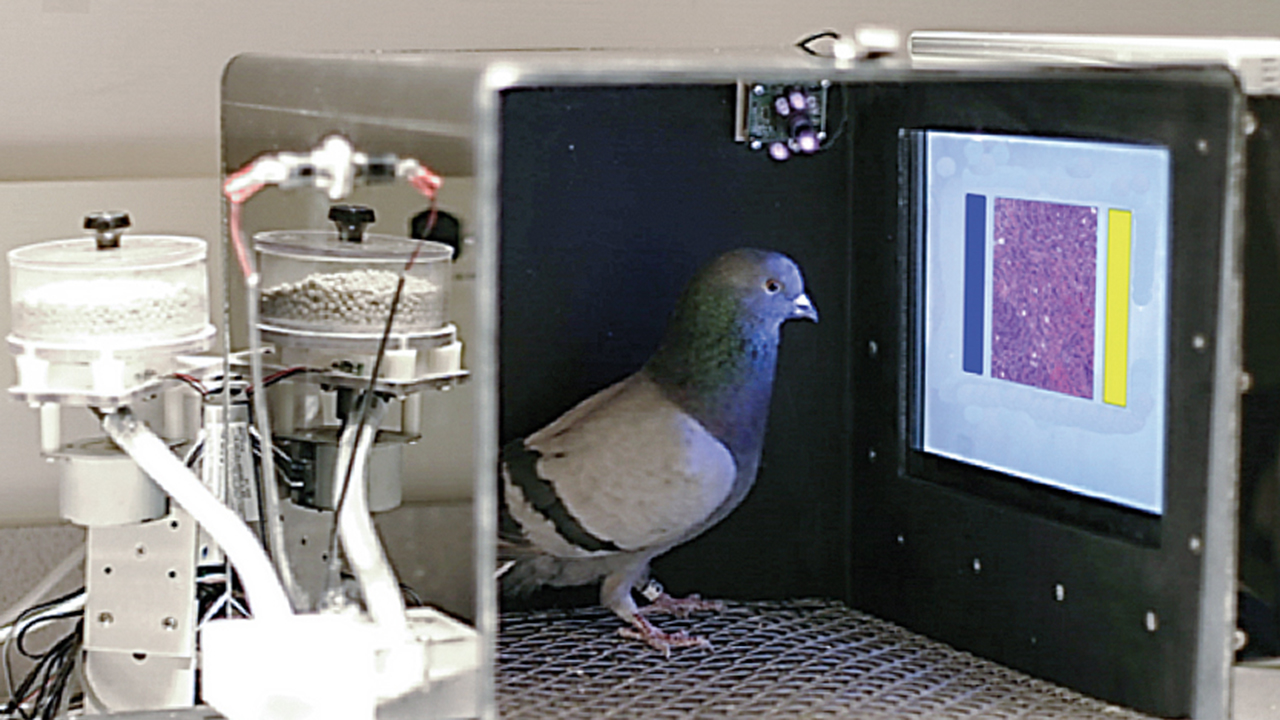

## 1. Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Activation
from keras.optimizers import Adam, Adagrad
from keras.utils import to_categorical, image_dataset_from_directory
import gc
import matplotlib.pyplot as plt
import seaborn as sns


2024-06-22 08:55:47.935645: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-22 08:55:47.935780: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-22 08:55:48.080981: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 2. Load label datasets

To save myself some ram I will load the training and testing image data later.

In [2]:
# load the training label data
df = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")

## 3. EDA

Let's quickly go thorugh what we have here in this dataset, and so we know how to approach it.

In [3]:
print("Shape of the dataset: ", df.shape)
print(df.head())
print(df.tail())

Shape of the dataset:  (220025, 2)
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
                                              id  label
220020  53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6      0
220021  d4b854fe38b07fe2831ad73892b3cec877689576      1
220022  3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75      0
220023  f129691c13433f66e1e0671ff1fe80944816f5a2      0
220024  a81f84895ddcd522302ddf34be02eb1b3e5af1cb      1


We have 220025 images in the training set, we can consider ourselves having sufficient data for a CNN model.

In [5]:
print("The ratio of each ", df["label"].value_counts()/len(df))

The ratio of each  label
0    0.594969
1    0.405031
Name: count, dtype: float64


Text(0, 0.5, 'Count')

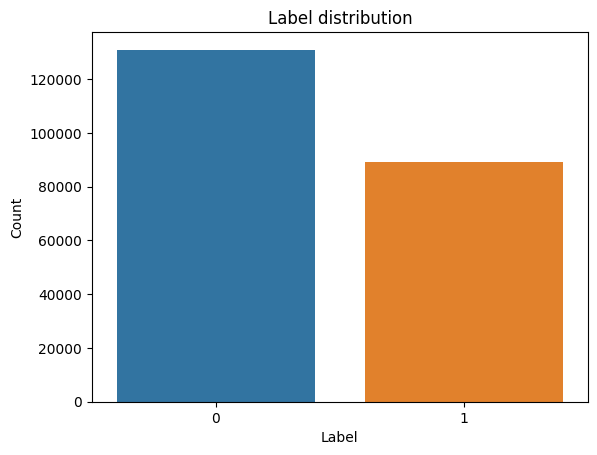

In [6]:
# Let's visualize the dataset 
ax = sns.countplot(data=df, x=df["label"])
ax.set_title("Label distribution")
ax.set_xlabel("Label")
ax.set_ylabel("Count")

From the label ratio and the histogram above, we can see that in the training set there are more non-cancer (0) images than cancer (1) images, 60/40 split. We will need to see our training result to decide on if this slight bias will actually need to be balanced.

In [7]:
# Now let's also look at the image size 
img = plt.imread("/kaggle/input/histopathologic-cancer-detection/train/" + df.iloc[0]["id"] + '.tif')
print("Image size: ", img.shape)

Image size:  (96, 96, 3)


According to the given dataset description, "a positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue", therefore we can see the center detection area is only 1/9 of the image.
Also we should note that "Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image."

In [8]:
# Let's look at some images and see if we can figure out the pattern ourselves

non_cancer = df.loc[df["label"] == 0]["id"].values
print(non_cancer)
cancer = df.loc[df["label"] == 1]["id"].values
print(cancer)

['f38a6374c348f90b587e046aac6079959adf3835'
 '755db6279dae599ebb4d39a9123cce439965282d'
 'bc3f0c64fb968ff4a8bd33af6971ecae77c75e08' ...
 '53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6'
 '3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75'
 'f129691c13433f66e1e0671ff1fe80944816f5a2']
['c18f2d887b7ae4f6742ee445113fa1aef383ed77'
 'a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da'
 '7f6ccae485af121e0b6ee733022e226ee6b0c65f' ...
 '309210db7f424edbc22b2d13bf2fa27518b18f5c'
 'd4b854fe38b07fe2831ad73892b3cec877689576'
 'a81f84895ddcd522302ddf34be02eb1b3e5af1cb']


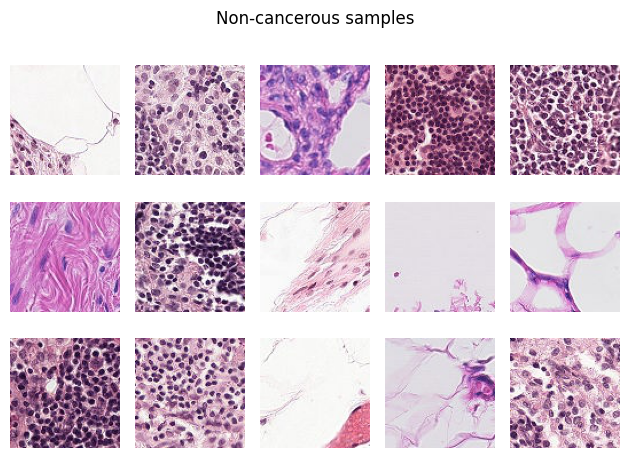

In [9]:
images_per_cat = 15

# Prepare figure with subplots: 3 rows and 5 columns
fig, axes = plt.subplots(nrows=3, ncols=5)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Load and display images for non-cancerous cases
for i, img_id in enumerate(non_cancer[:images_per_cat]):
    img = plt.imread(f"/kaggle/input/histopathologic-cancer-detection/train/{img_id}.tif")
    axes[i].imshow(img)
#     axes[i].set_title("Non-Cancer")
    axes[i].axis('off')  # Turn off axis
    
plt.suptitle("Non-cancerous samples")
plt.tight_layout()
plt.show()

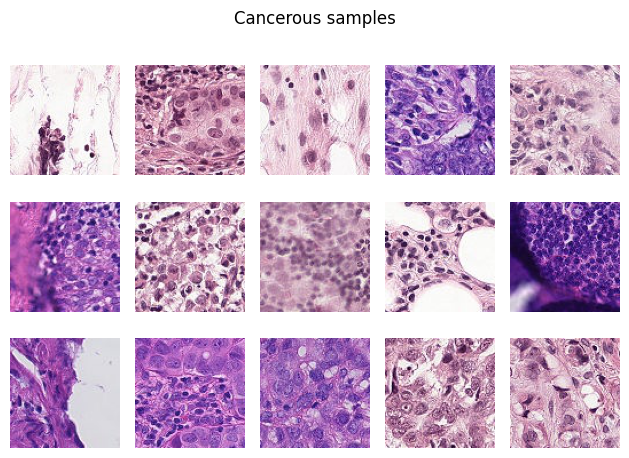

In [10]:
images_per_cat = 15

# Prepare figure with subplots: 3 rows and 5 columns
fig, axes = plt.subplots(nrows=3, ncols=5)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Load and display images for cancerous cases
for i, img_id in enumerate(cancer[:images_per_cat]):
    img = plt.imread(f"/kaggle/input/histopathologic-cancer-detection/train/{img_id}.tif")
    axes[i].imshow(img)
#     axes[i].set_title("Cancer")
    axes[i].axis('off') 
    
plt.suptitle("Cancerous samples")
plt.tight_layout()
plt.show()

With my plain eyes, I have no clue how to catgorize these images. So let's get going with our architecture and let machine do the work.

## 4. Load traing data

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2, # use a classic 80/20 split
)


df['label'] = df['label'].astype(str) # datagen does not support binary labels in integer
df['id'] = df['id'].apply(lambda x: x + '.tif') # and we need to turn the id to readable image format

train_generator = train_datagen.flow_from_dataframe(
                dataframe=df,
                directory="/kaggle/input/histopathologic-cancer-detection/train",
                x_col="id",
                y_col="label",
                has_ext=False,
                subset="training",
                target_size=(96, 96),
                batch_size=32,
                shuffle=True,
                class_mode="binary"
                )
validation_generator = train_datagen.flow_from_dataframe(
                dataframe=df,
                directory="/kaggle/input/histopathologic-cancer-detection/train",
                x_col ="id",
                y_col ="label",
                has_ext=False,
                subset="validation",
                target_size=(96, 96),
                batch_size=32,
                shuffle=True,
                class_mode="binary"
                )

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [12]:
collected = gc.collect()
print(f"Gotta catch'em all! Collected {collected} objects")

Gotta catch'em all! Collected 29518 objects


## 5. Define classification model

We will start simple with an architecture that includes **three convolutional blocs** with increasing filter sizes (32, 64, 128).

We will use relu for activation as it has nice non-linear quality.

After each convolutional operation and before activation we will also try use bacth normalization to adjust and scale the input for activation, this may help us to stablize the learning a bit better. (I think so)

At the end of each convolutional bloc we will use a 2x2 maxpool to reduce the size of the feature map so that it is not so computationally expensive, as it is already very costly to run now.

Then, we add some dropouts to each bloc, to regularize the training and avoid overfitting our model.

In the **final dense layer** we basically repeat the above structure, and ends with a sigmoid activation for binary classification.

Let's give it a try.

In [13]:
# Let's initialize model parameters 
kernel_size = (3,3)
pool_size= (2,2)
filter1 = 32
filter2 = 64
filter3 = 128
dense_nn = 256
dropout_conv = 0.2
dropout_dense = 0.4

#initialize the model 
model = Sequential()

# conv bloc 1
model.add(Conv2D(filter1, kernel_size, input_shape=(96,96,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(filter1, kernel_size))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(dropout_conv))

# conv bloc 2
model.add(Conv2D(filter2, kernel_size))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(filter2, kernel_size))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(dropout_conv))

# conv bloc 3
model.add(Conv2D(filter3, kernel_size))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(filter3, kernel_size))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(dropout_conv))

# dense layer
model.add(Flatten())
model.add(Dense(dense_nn))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))

# final classfication layer with sigmoid
model.add(Dense(1, activation="sigmoid"))

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 94, 94, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 94, 94, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 92, 92, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 92, 92, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 92, 92, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 44, 44, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 44, 44, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 42, 42, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 42, 42, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 42, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 17, 17, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 17, 17, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 17, 17, 128)    │             

 Total params: 2,387,489 (9.11 MB)

 Trainable params: 2,386,081 (9.10 MB)

 Non-trainable params: 1,408 (5.50 KB)

we now need to complie the model to start training
we will be using cross entropy and adam for this pass and get the accuracy score and recall for observing the model performance

In [14]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        keras.metrics.BinaryAccuracy(),
        keras.metrics.Recall(),
    ],
)

## 6. Model training and results analysis

In [15]:
# calculate number of steps per epoch
step_size_train=train_generator.n//train_generator.batch_size
step_size_valid=validation_generator.n//validation_generator.batch_size

print(step_size_train)
print(step_size_valid)

5500
1375


In [16]:
# training process

# I realized I should probabaly save weights from each epoch
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'model_epoch_{epoch:02d}.weights.h5', 
    save_weights_only=True, 
    save_best_only=False, 
    save_freq='epoch'
)

history = model.fit(
    train_generator,
    batch_size=64,
    epochs=5,
    verbose="auto",
    callbacks=[checkpoint], #we will see if need to stop early
    steps_per_epoch=step_size_train,
    validation_data=validation_generator,
    validation_steps=step_size_valid,
)

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-06-22 09:31:30.350931: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8836: 6.17839, expected 5.44963
2024-06-22 09:31:30.351001: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8839: 5.09095, expected 4.36218
2024-06-22 09:31:30.351018: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8843: 6.28436, expected 5.55559
2024-06-22 09:31:30.351034: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8845: 5.83888, expected 5.11011
2024-06-22 09:31:30.351055: E external/local_xla/xla/service/gpu/buffer_comp

   1/5500 ━━━━━━━━━━━━━━━━━━━━ 31:22:17 21s/step - binary_accuracy: 0.5000 - loss: 0.7800 - recall: 0.3333

I0000 00:00:1719048699.391898      87 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1751/5500 ━━━━━━━━━━━━━━━━━━━━ 13:00 208ms/step - binary_accuracy: 0.7964 - loss: 0.4653 - recall: 0.7227

2024-06-22 09:37:47.563876: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 44180: 7.15656, expected 6.24082
2024-06-22 09:37:47.563940: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 44181: 8.03765, expected 7.12192
2024-06-22 09:37:47.563955: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 44182: 7.32376, expected 6.40803
2024-06-22 09:37:47.563969: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 44183: 6.00329, expected 5.08755
2024-06-22 09:37:47.563986: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 44184: 6.93475, expected 6.01901
2024-06-22 09:37:47.564002: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 44185: 7.6303, expected 6.71456
2024-06-22 09:37:47.564013: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 44186: 7.59534, expected 6.6796
2024-06-22 09:37:47.564026: E

5500/5500 ━━━━━━━━━━━━━━━━━━━━ 1528s 274ms/step - binary_accuracy: 0.8252 - loss: 0.4048 - recall: 0.7635 - val_binary_accuracy: 0.7455 - val_loss: 0.5714 - val_recall: 0.3739
Epoch 2/5
   1/5500 ━━━━━━━━━━━━━━━━━━━━ 1:37 18ms/step - binary_accuracy: 0.9375 - loss: 0.1653 - recall: 1.0000

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-06-22 09:56:46.826377: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 44180: 8.02016, expected 7.07077
2024-06-22 09:56:46.826438: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 44182: 7.26606, expected 6.31667
2024-06-22 09:56:46.826449: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 44183: 7.47131, expected 6.52192
2024-06-22 09:56:46.826459: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 44184: 7.1578, expected 6.20841
2024-06-22 09:56:46.826468: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 44185: 8.13563, ex

5500/5500 ━━━━━━━━━━━━━━━━━━━━ 1s 203us/step - binary_accuracy: 0.9375 - loss: 0.1653 - recall: 1.0000 - val_binary_accuracy: 0.8000 - val_loss: 0.2518 - val_recall: 0.0000e+00
Epoch 3/5


W0000 00:00:1719050207.646465      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5500/5500 ━━━━━━━━━━━━━━━━━━━━ 350s 64ms/step - binary_accuracy: 0.8918 - loss: 0.2709 - recall: 0.8427 - val_binary_accuracy: 0.8765 - val_loss: 0.3062 - val_recall: 0.8787
Epoch 4/5
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 25us/step - binary_accuracy: 0.8438 - loss: 0.3034 - recall: 0.7778 - val_binary_accuracy: 1.0000 - val_loss: 0.0295 - val_recall: 1.0000
Epoch 5/5
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 354s 64ms/step - binary_accuracy: 0.9134 - loss: 0.2230 - recall: 0.8732 - val_binary_accuracy: 0.7655 - val_loss: 0.5846 - val_recall: 0.4224


In [17]:
collected = gc.collect()
print(f"Gotta catch'em all! Collected {collected} objects")

Gotta catch'em all! Collected 2490 objects


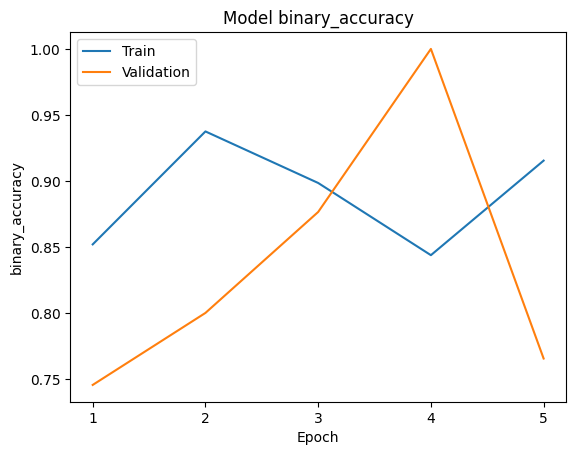

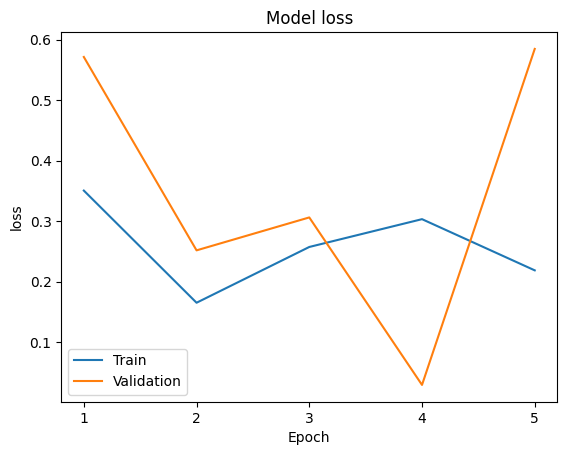

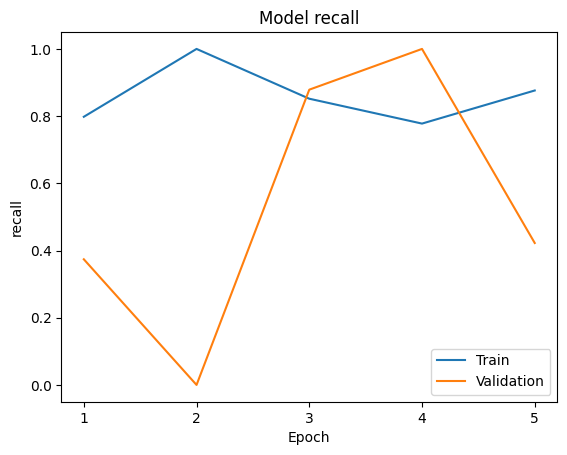

In [29]:
# Visualize the metrics from history
def show_metric(history, metric_name):
    plt.plot(history.history[metric_name])
    plt.plot(history.history["val_" + metric_name])
    plt.xticks(history.epoch, [str(e + 1) for e in history.epoch])
    plt.title("Model " + metric_name)
    plt.xlabel("Epoch")
    plt.ylabel(metric_name)
    plt.legend(["Train", "Validation"])
    plt.show()

show_metric(history, "binary_accuracy")
show_metric(history, "loss")
show_metric(history, "recall")

Let's analyze the training result a bit.
1. From the Model accuracy graph, we can see that the model had the highest validation accurcy at the fourth epoch, despite a somewhat lower training accuracy.
2. The validation loss was also the lowest for the fourth epoch.
3. The validation recall is the highest for the fourth epoch too.


I think overall the model seems to be in a good shape with good hyperparameters, and the fourth epoch is yielding the best performance so far with "- val_binary_accuracy: 1.0000 - val_loss: 0.0295 - val_recall: 1.0000"

Let's keep the weights from the fourth epoch and slightly increase the dropout rate and keep the current learning rate.

In [30]:
# Second iteration of model

# Let's initialize model parameters 
kernel_size = (3,3)
pool_size= (2,2)
filter1 = 32
filter2 = 64
filter3 = 128
dense_nn = 256

# we will use dropout to regularize the training and avoid overfitting
dropout_conv = 0.3
dropout_dense = 0.5

#initialize the model 
model2 = Sequential()

# conv bloc 1
model2.add(Conv2D(filter1, kernel_size, input_shape=(96,96,3)))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(Conv2D(filter1, kernel_size))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPooling2D(pool_size=pool_size))
model2.add(Dropout(dropout_conv))

# conv bloc 2
model2.add(Conv2D(filter2, kernel_size))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(Conv2D(filter2, kernel_size))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPooling2D(pool_size=pool_size))
model2.add(Dropout(dropout_conv))

# conv bloc 3
model2.add(Conv2D(filter3, kernel_size))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(Conv2D(filter3, kernel_size))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPooling2D(pool_size=pool_size))
model2.add(Dropout(dropout_conv))

# dense layer
model2.add(Flatten())
model2.add(Dense(dense_nn))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(Dropout(dropout_dense))

# final classfication layer with sigmoid
model2.add(Dense(1, activation="sigmoid"))

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 94, 94, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 94, 94, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 92, 92, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 92, 92, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 92, 92, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 44, 44, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 44, 44, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 42, 42, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 42, 42, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 42, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 17, 17, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 17, 17, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 17, 17, 128)    │             

 Total params: 2,387,489 (9.11 MB)

 Trainable params: 2,386,081 (9.10 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [34]:
# Use the weights from 4th epoch
model2.load_weights('model_epoch_04.weights.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [39]:
# recompile the model after loading the weights
model2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        keras.metrics.BinaryAccuracy(),
        keras.metrics.Recall(),
    ],
)

In [36]:
checkpoint2 = ModelCheckpoint(
    'model2_epoch_{epoch:02d}.weights.h5', 
    save_weights_only=True, 
    save_best_only=False, 
    save_freq='epoch'
)

history2 = model.fit(
    train_generator,
    batch_size=64,
    epochs=5,
    verbose="auto",
    callbacks=[checkpoint2],
    steps_per_epoch=step_size_train,
    validation_data=validation_generator,
    validation_steps=step_size_valid,
)

Epoch 1/5
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 360s 65ms/step - binary_accuracy: 0.9234 - loss: 0.2008 - recall: 0.8881 - val_binary_accuracy: 0.9176 - val_loss: 0.2159 - val_recall: 0.8765
Epoch 2/5
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 25us/step - binary_accuracy: 0.8750 - loss: 0.2031 - recall: 0.8235 - val_binary_accuracy: 0.8000 - val_loss: 0.2112 - val_recall: 1.0000
Epoch 3/5
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 359s 65ms/step - binary_accuracy: 0.9316 - loss: 0.1827 - recall: 0.9015 - val_binary_accuracy: 0.9218 - val_loss: 0.2046 - val_recall: 0.8843
Epoch 4/5
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 27us/step - binary_accuracy: 0.9688 - loss: 0.0850 - recall: 1.0000 - val_binary_accuracy: 0.8000 - val_loss: 0.3218 - val_recall: 1.0000
Epoch 5/5
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 370s 67ms/step - binary_accuracy: 0.9360 - loss: 0.1741 - recall: 0.9055 - val_binary_accuracy: 0.9090 - val_loss: 0.2312 - val_recall: 0.8186


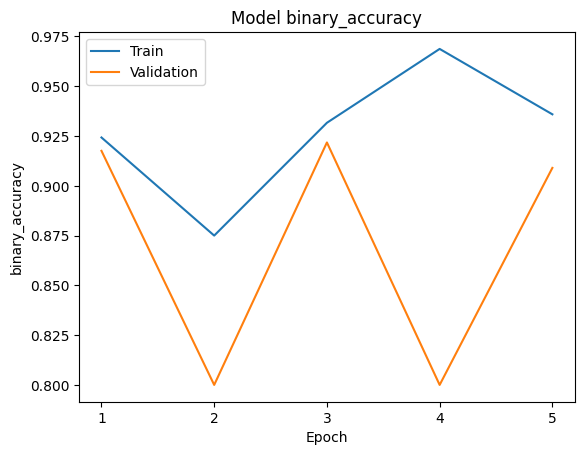

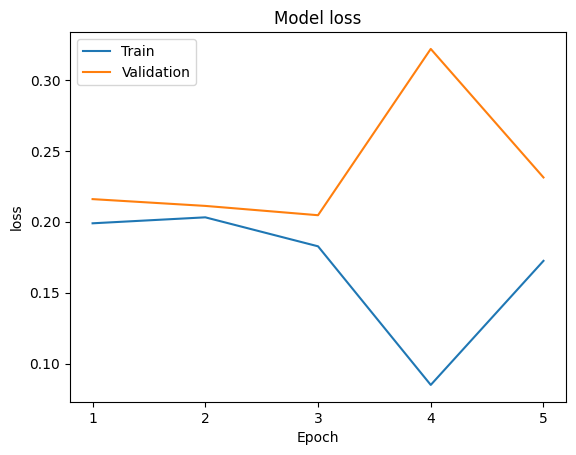

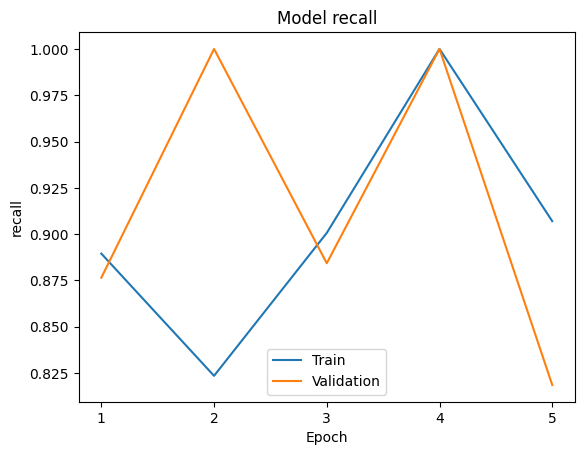

In [37]:
show_metric(history2, "binary_accuracy")
show_metric(history2, "loss")
show_metric(history2, "recall")

Now the 2nd iteration of the model, although the model performance start to fluctuate a lot, but if we look carefully that's due to the change of scale. In general we see an increase in the performance.
1. in the first plot we can see the validation accuracy is the highest for the 1st, 3rd and 5th epochs. But in general the model accuracy is above 0.8.
2. The validation loss are lower for the first three epochs. In general the loss are lower than 0.3.
3. The recall score are the highest for 2nd and 4th epochs, but in general the recall scores are higher then 0.8.

It a bit difficult to decide on how to trade off between accuracy and recall, but considering the overall performance, let;s choose weights from 1st epoch as our safety pick here.

**As our model structure seems to be responding pretty good, I will not change the general architecture but use Adagrad as optimizer instead and see if there are any change to the result we get.**

In [38]:
# Use the weights from 1rd epoch
model2.load_weights('model2_epoch_01.weights.h5')

In [40]:
# recompile the model after loading the weights
# and this time use Adagrad instead of Adam
model2.compile(
    optimizer=keras.optimizers.Adagrad(learning_rate=1e-3),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        keras.metrics.BinaryAccuracy(),
        keras.metrics.Recall(),
    ],
)

In [41]:
checkpoint3 = ModelCheckpoint(
    'model3_epoch_{epoch:02d}.weights.h5', 
    save_weights_only=True, 
    save_best_only=False, 
    save_freq='epoch'
)

history3 = model.fit(
    train_generator,
    batch_size=64,
    epochs=5,
    verbose="auto",
    callbacks=[checkpoint3],
    steps_per_epoch=step_size_train,
    validation_data=validation_generator,
    validation_steps=step_size_valid,
)

Epoch 1/5
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 471s 86ms/step - binary_accuracy: 0.9394 - loss: 0.1623 - recall: 0.9115 - val_binary_accuracy: 0.9234 - val_loss: 0.1941 - val_recall: 0.9069
Epoch 2/5
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 26us/step - binary_accuracy: 0.9375 - loss: 0.1334 - recall: 0.8750 - val_binary_accuracy: 1.0000 - val_loss: 0.0297 - val_recall: 1.0000
Epoch 3/5
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 364s 66ms/step - binary_accuracy: 0.9416 - loss: 0.1558 - recall: 0.9158 - val_binary_accuracy: 0.8953 - val_loss: 0.2575 - val_recall: 0.7520
Epoch 4/5
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 27us/step - binary_accuracy: 0.9688 - loss: 0.0796 - recall: 1.0000 - val_binary_accuracy: 0.8000 - val_loss: 0.5394 - val_recall: 0.6667
Epoch 5/5
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 360s 65ms/step - binary_accuracy: 0.9450 - loss: 0.1460 - recall: 0.9195 - val_binary_accuracy: 0.7963 - val_loss: 1.1884 - val_recall: 0.5160


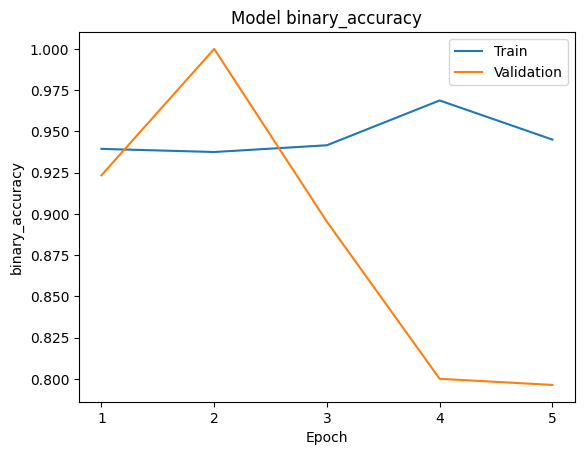

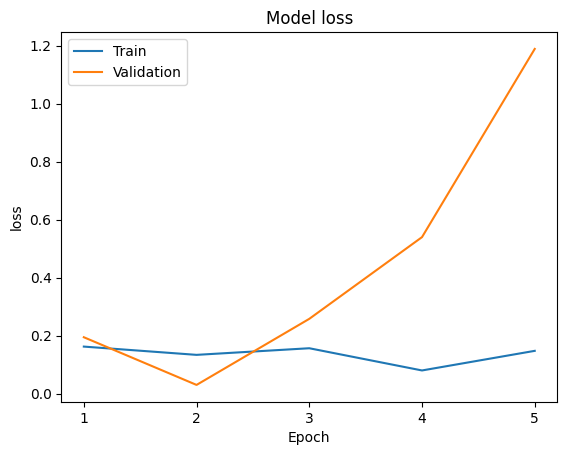

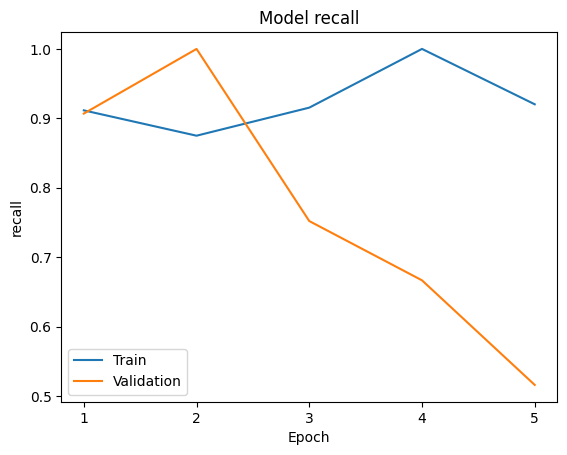

In [42]:
show_metric(history3, "binary_accuracy")
show_metric(history3, "loss")
show_metric(history3, "recall")

In our last iteration things start to become clearer.
1. Model's validation accuracy started decreasing after the second epoch.
2. The validation loss started increasing after the second epoch.
3. Model's recal score decreased after the second epoch.

Therefore, it is clear that after the second epoch, our model was overfitting and stopped being performative. And compare to previous training iteration, second epoch also yielded very good result "- val_binary_accuracy: 0.9234 - val_loss: 0.1941 - val_recall: 0.9069"

So I will keep the current model architecture and use the weights from 2nd epoch.

In [43]:
# Use the weights from 2nd epoch
model2.load_weights('model3_epoch_02.weights.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adagrad', because it has 2 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [44]:
# recompile the model after loading the weights
# and this time use Adagrad instead of Adam
model2.compile(
    optimizer=keras.optimizers.Adagrad(learning_rate=1e-3),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        keras.metrics.BinaryAccuracy(),
        keras.metrics.Recall(),
    ],
)

## 7. Create submission

In [45]:
# load the test data

test_datagen = ImageDataGenerator(
    rescale=1./255
)


test_files = os.listdir("/kaggle/input/histopathologic-cancer-detection/test")
test_df = pd.DataFrame(test_files, columns=["id"])
print(test_df)


test_generator = test_datagen.flow_from_dataframe(
                dataframe=test_df,
                directory="/kaggle/input/histopathologic-cancer-detection/test",
                x_col="id",
                has_ext=True,
                target_size=(96, 96),
                batch_size=32,
                shuffle=True,
                class_mode=None
)

                                                 id
0      a7ea26360815d8492433b14cd8318607bcf99d9e.tif
1      59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif
2      5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif
3      bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif
4      523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif
...                                             ...
57453  7907c88a7f5f9c8ca5b2df72c1e6ff9650eea22b.tif
57454  2a6fc1ed16fa94d263efab330ccbeb1906cbd421.tif
57455  6bb5c0611c0ccf4713e0ccbc0e8c54bcb498ef14.tif
57456  f11e7c9e77cbc1ec916a52e6b871a293ee1bb928.tif
57457  66d529ceeb28e822fac5e1378cc5702194532127.tif

[57458 rows x 1 columns]
Found 57458 validated image filenames.


In [46]:
# Finally, let's make prediction using the test data we just loaded
pred = model2.predict(test_generator)
pred = np.transpose(pred)[0]
print(pred)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1795/1796 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step

2024-06-22 11:58:13.066076: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1169: 5.18307, expected 4.53467
2024-06-22 11:58:13.066149: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1539: 5.09214, expected 4.44374
2024-06-22 11:58:13.066171: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2187: 5.47877, expected 4.83037
2024-06-22 11:58:13.066206: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4250: 5.16469, expected 4.51629
2024-06-22 11:58:13.066233: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5885: 5.34781, expected 4.69941
2024-06-22 11:58:13.066268: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8836: 6.81719, expected 5.85922
2024-06-22 11:58:13.066280: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8837: 7.96806, expected 7.01009
2024-06-22 11:58:13.066291: E exte

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 348s 193ms/step
[0.6793062  0.17249043 0.11405455 ... 0.00899622 0.97347057 0.00678501]


In [47]:
# now we gotta convert these probabilities to binary label
binary_pred = (pred >= 0.5).astype(int)
print(binary_pred)

[1 0 0 ... 0 1 0]


In [49]:
#prepare submission file
test_df["id"] = test_df["id"].str.replace(".tif", "")
test_df["label"] = binary_pred
print(test_df)
test_df.to_csv("submission.csv", index=False)


                                             id  label
0      a7ea26360815d8492433b14cd8318607bcf99d9e      1
1      59d21133c845dff1ebc7a0c7cf40c145ea9e9664      0
2      5fde41ce8c6048a5c2f38eca12d6528fa312cdbb      0
3      bd953a3b1db1f7041ee95ff482594c4f46c73ed0      0
4      523fc2efd7aba53e597ab0f69cc2cbded7a6ce62      1
...                                         ...    ...
57453  7907c88a7f5f9c8ca5b2df72c1e6ff9650eea22b      0
57454  2a6fc1ed16fa94d263efab330ccbeb1906cbd421      0
57455  6bb5c0611c0ccf4713e0ccbc0e8c54bcb498ef14      0
57456  f11e7c9e77cbc1ec916a52e6b871a293ee1bb928      1
57457  66d529ceeb28e822fac5e1378cc5702194532127      0

[57458 rows x 2 columns]


In [50]:
from IPython.display import FileLink
FileLink(r'submission.csv')


/kaggle/working/submission.csv

## Conclusion

Eventually, we got an accuracy score around 0.5, which means that there are still quite some rooms for model improvement. The current model architecture is not too complex or deep, nor did we do significant modification during training. 
Thus, the reasonable next steps for iteratively imrpove our model include:
1. Increase the model layers
2. Change regularization technique
3. Hyper parameter tuning

I still believe that the current dropout rate and learning rate are appropriate, yet in case of model architecture change, they should be reevaluated according to model performance.

Unfortunately, the current CNN is not winning over pigeons in cancer screening classification, as the pigeons had an accuracy around 80%.